## Keras model - Deeper2
---- 

* **features**

> - 1. Three layers of Convolution block(VGG alike; conv + conv + pooling ~ activation == relu)
> - 2. one of FCN layer with *200* nodes, activation = elu 
>      >  * $elu(x) = \exp{(\mathbf{x})} \ if \ x < 0, \  else \ \mathbf{x}$
> - 3. NO 1x1 conv, which was for making it to gray scaled  
> - 4. Using image size = 250, 550, 3 

In [20]:
import numpy as np 
import pickle 

with open('../sample_image/sample560_crop_df.bin', 'rb') as f :
    crop_img = pickle.load(f)
    
X = np.array([i for i in crop_img.crop_images])
y = crop_img.weight.values

# idx = list(np.random.randint(0, len(X), int(len(X) * 0.8)))
# test_idx = list(set(list(range(len(X)))) - set(idx))
idx = list(np.random.choice(range(len(X)), int(len(X) * 0.8), replace=False))
test_idx = list(set(list(range(len(X)))) - set(idx))


X_train = X[idx]
y_train = y[idx]

X_test = X[test_idx]
y_test = y[test_idx]


### Parameters 

In [21]:
BATCH_SIZE = 24 
LOSS = "mean_squared_error"
OPTIMIZER = ["adagrad", "adadelta", "adam", "adamax", "rmsprob"]


### Model Architecture

In [22]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.layers import Dropout
from keras import regularizers 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2


def cnn_model():
    model = Sequential()
    #  first layer for making images to the gray scale images, more precisely 
    # model.add(Conv2D(1, (1, 1), activation='relu', input_shape=(250, 550, 3), padding='same', kernel_regularizer=l2(0.001)))

    # 
    model.add(Conv2D(32, (7, 7), activation='relu', padding='same', input_shape=(250, 550, 3), kernel_regularizer=l2(0.001)))
    model.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (7, 7), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (7, 7), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (7, 7), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (7, 7), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(127, activation='elu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='elu'))
    
    return model 

In [23]:
from keras.utils.training_utils import multi_gpu_model

model = cnn_model()
model = multi_gpu_model(model, gpus=2)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [24]:
%%time
hist = model.fit(X_train, y_train, epochs=50, batch_size=24, validation_data=(X_test, y_test), verbose=2)

Train on 448 samples, validate on 112 samples
Epoch 1/50
 - 34s - loss: 1844.2404 - mean_absolute_error: 31.6853 - val_loss: 1305483.7143 - val_mean_absolute_error: 1132.1017
Epoch 2/50
 - 30s - loss: 416.4648 - mean_absolute_error: 16.5403 - val_loss: 136232.6708 - val_mean_absolute_error: 363.4231
Epoch 3/50
 - 29s - loss: 488.7251 - mean_absolute_error: 17.4980 - val_loss: 17975.7413 - val_mean_absolute_error: 131.9705
Epoch 4/50
 - 29s - loss: 353.8095 - mean_absolute_error: 15.1611 - val_loss: 10198.2520 - val_mean_absolute_error: 99.1627
Epoch 5/50
 - 30s - loss: 294.0738 - mean_absolute_error: 13.7423 - val_loss: 3085.4313 - val_mean_absolute_error: 54.1480
Epoch 6/50
 - 29s - loss: 392.1718 - mean_absolute_error: 15.8018 - val_loss: 1300.8426 - val_mean_absolute_error: 35.3108
Epoch 7/50
 - 30s - loss: 390.9498 - mean_absolute_error: 15.9996 - val_loss: 354.5142 - val_mean_absolute_error: 17.8088
Epoch 8/50
 - 29s - loss: 337.8860 - mean_absolute_error: 14.4398 - val_loss: 727.

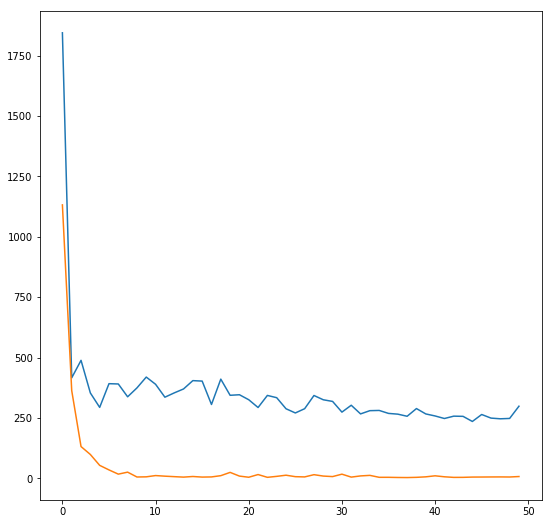

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9,9))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_mean_absolute_error"])
plt.show()

In [26]:
r = 2
print("prediction : {}, Truth : {} ".format(model.predict(X_test)[r], y_test[r]))

prediction : [115.814735], Truth : 122.39 
